<a href="https://colab.research.google.com/github/vicknentura/ML-in-SQL-BigQuery/blob/main/Google_Cloud_x_MLB(TM)_Hackathon_Exploring_MLB_Provided_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description
---

This notebook shows how to get started with the MLB-provided datasets for the [Google Cloud x MLB(TM) Hackathon](https://next2025challenge.devpost.com/).

#Setup
---

In [3]:
#@title Import Python Libraries
# General data science libraries
import pandas as pd
import numpy as np

# Pulling data from APIs, parsing JSON
import requests
import json

# Interfacing w/ Cloud Storage from Python
from google.cloud import storage

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import HTML, Image

In [4]:
#@title Modify Settings

# Expand max column width when displaying data frames to handle longer text
pd.set_option('display.max_colwidth', 200)

In [5]:
#@title Function to Load Newline Delimited JSON into Pandas DF
def load_newline_delimited_json(url):
    """Loads a newline-delimited JSON file from a URL into a pandas DataFrame.

    Args:
        url: The URL of the newline-delimited JSON file.

    Returns:
        A pandas DataFrame containing the data, or None if an error occurs.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes

        data = []
        for line in response.text.strip().split('\n'):
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {line} due to error: {e}")

        return pd.DataFrame(data)
    except requests.exceptions.RequestException as e:
        print(f"Error downloading data: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Exploring MLB Stats API
---
The MLB Stats API ([see documentation here](https://console.cloud.google.com/storage/browser/gcp-mlb-hackathon-2025/datasets/mlb-statsapi-docs)) provides access to various MLB historical and present day data feeds, without authentication. The various data feeds here should be very useful in making progress on this project. The cells below show how to access data from various MLB Stats API endpoints and do some initial processing.

In [6]:
#@title Function to Process Results from Various MLB Stats API Endpoints
def process_endpoint_url(endpoint_url, pop_key=None):
  """
  Fetches data from a URL, parses JSON, and optionally pops a key.

  Args:
    endpoint_url: The URL to fetch data from.
    pop_key: The key to pop from the JSON data (optional, defaults to None).

  Returns:
    A pandas DataFrame containing the processed data
  """
  json_result = requests.get(endpoint_url).content

  data = json.loads(json_result)

   # if pop_key is provided, pop key and normalize nested fields
  if pop_key:
    df_result = pd.json_normalize(data.pop(pop_key), sep = '_')
  # if pop_key is not provided, normalize entire json
  else:
    df_result = pd.json_normalize(data)

  return df_result

In [1]:
#@title Sports (Different Baseball Leagues/Levels/Competitions)
sports_endpoint_url = 'https://statsapi.mlb.com/api/v1/sports'

sports = process_endpoint_url(sports_endpoint_url, 'sports')

display(sports)

NameError: name 'process_endpoint_url' is not defined

In [22]:
import requests

def process_endpoint_url(url):
    response = requests.get(url)
    return response.json()

# Fetch leagues data
leagues_endpoint_url = 'https://statsapi.mlb.com/api/v1/league'
leagues = process_endpoint_url(leagues_endpoint_url)

# Convert the dictionary to a Pandas DataFrame to use .info()
leagues_df = pd.DataFrame(leagues) # Create a DataFrame from the dictionary

# Display leagues information using .info() on the DataFrame
leagues_df.info() # Call .info() on the DataFrame

print(leagues_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   copyright  116 non-null    object
 1   leagues    116 non-null    object
dtypes: object(2)
memory usage: 1.9+ KB
Index(['copyright', 'leagues'], dtype='object')


In [28]:
leagues_df = pd.json_normalize(leagues_df['leagues'], sep='_')
# leagues_df = pd.concat([leagues_df, leagues_expanded], axis=1)  # Remove this line
print(leagues_df['link'].head(16)) # assuming 'link' is a column in the expanded df

0     /api/v1/league/103
1     /api/v1/league/104
2     /api/v1/league/114
3     /api/v1/league/115
4     /api/v1/league/117
5     /api/v1/league/112
6     /api/v1/league/138
7     /api/v1/league/139
8     /api/v1/league/113
9     /api/v1/league/111
10    /api/v1/league/109
11    /api/v1/league/147
12    /api/v1/league/148
13    /api/v1/league/116
14    /api/v1/league/118
15    /api/v1/league/126
Name: link, dtype: object


In [31]:
# Base URL for the API
base_url = 'https://statsapi.mlb.com'  # Adjusted base URL

all_league_data = []  # List to store data from all links

for link in leagues_df['link']:
    try:
        # Construct the full URL
        full_url = base_url + link
        league_data = process_endpoint_url(full_url)  # Fetch data using the full URL

        # Append the league_data to all_league_data
        all_league_data.append(pd.DataFrame(league_data))  # Convert dict to DataFrame before appending

    except Exception as e:
        print(f"Error processing link {full_url}: {e}")

# Concatenate all league data into a single DataFrame
all_leagues_df = pd.concat(all_league_data, ignore_index=True)

# Now you can inspect the data in all_leagues_df
print(all_leagues_df.head())
print(all_leagues_df.info())

                                                                                                                                                              copyright  \
0  Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt   
1  Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt   
2  Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt   
3  Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt   
4  Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/co

In [32]:
# Base URL for the API
base_url = 'https://statsapi.mlb.com'  # Adjusted base URL

all_league_data = []  # List to store data from all links

for link in leagues_df['link']:
    try:
        # Construct the full URL
        full_url = base_url + link
        league_data = process_endpoint_url(full_url)  # Fetch data using the full URL

        # Append the league_data to all_league_data
        all_league_data.append(pd.DataFrame(league_data))  # Convert dict to DataFrame before appending

    except Exception as e:
        print(f"Error processing link {full_url}: {e}")

# Concatenate all league data into a single DataFrame
all_leagues_df = pd.concat(all_league_data, ignore_index=True)

# Now you can inspect the data in all_leagues_df
print(all_leagues_df.head())
print(all_leagues_df.info())

                                                                                                                                                              copyright  \
0  Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt   
1  Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt   
2  Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt   
3  Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt   
4  Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/co

In [ ]:
#@title Seasons

# Use "?sportId=1" in following URL for MLB only
# Can also add "&withGameTypeDates=true" at end to get much more info on games
seasons_endpoint_url = 'https://statsapi.mlb.com/api/v1/seasons/all?sportId=1'

seasons = process_endpoint_url(seasons_endpoint_url, 'seasons')

display(seasons)

,seasonId,hasWildcard,preSeasonStartDate,seasonStartDate,regularSeasonStartDate,regularSeasonEndDate,seasonEndDate,offseasonStartDate,offSeasonEndDate,seasonLevelGamedayType,...,qualifierPlateAppearances,qualifierOutsPitched,postSeasonStartDate,postSeasonEndDate,lastDate1stHalf,allStarDate,firstDate2ndHalf,preSeasonEndDate,springStartDate,springEndDate
0,1876,False,1876-01-01,1876-04-22,1876-04-22,1876-10-09,1876-10-09,1876-10-10,1877-04-29,S,...,3.1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1877,False,1877-01-01,1877-04-30,1877-04-30,1877-10-06,1877-10-06,1877-10-07,1878-04-30,S,...,3.1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1878,False,1878-01-01,1878-05-01,1878-05-01,1878-09-30,1878-09-30,1878-10-01,1879-04-30,S,...,3.1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1879,False,1879-01-01,1879-05-01,1879-05-01,1879-09-30,1879-09-30,1879-10-01,1880-04-30,S,...,3.1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1880,False,1880-01-01,1880-05-01,1880-05-01,1880-10-01,1880-10-01,1880-10-02,1881-04-29,S,...,3.1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2022,True,2022-01-01,2022-02-27,2022-04-07,2022-10-05,2022-11-05,2022-11-06,2022-12-31,P,...,3.1,3.0,2022-10-07,2022-11-05,2022-07-17,2022-07-19,2022-07-21,2022-02-26,2022-02-27,2022-04-06
147,2023,True,2023-01-01,2023-02-24,2023-03-30,2023-10-02,2023-11-01,2023-11-02,2023-12-31,P,...,3.1,3.0,2023-10-03,2023-11-01,2023-07-09,2023-07-11,2023-07-14,2023-02-23,2023-02-24,2023-03-28
148,2024,True,2024-01-01,2024-02-22,2024-03-20,2024-09-30,2024-10-30,2024-10-31,2024-12-31,P,...,3.1,3.0,2024-10-01,2024-10-30,2024-07-14,2024-07-16,2024-07-19,2024-02-21,2024-02-22,2024-03-26
149,2025,True,2025-01-01,2025-02-20,2025-03-26,2025-09-28,2025-10-31,2025-11-01,2025-12-31,P,...,3.1,3.0,2025-09-30,2025-10-31,2025-07-14,2025-07-15,2025-07-19,2025-02-19,2025-02-20,2025-03-25


In [ ]:
#@title Teams
# Use "?sportId=1" in following URL for MLB only
teams_endpoint_url = 'https://statsapi.mlb.com/api/v1/teams?sportId=1'

teams = process_endpoint_url(teams_endpoint_url, 'teams')

display(teams)

,allStarStatus,id,name,link,season,teamCode,fileCode,abbreviation,teamName,locationName,...,springVenue_link,league_id,league_name,league_link,division_id,division_name,division_link,sport_id,sport_link,sport_name
0,N,133,Athletics,/api/v1/teams/133,2025,ath,ath,ATH,Athletics,Sacramento,...,/api/v1/venues/2507,103,American League,/api/v1/league/103,200,American League West,/api/v1/divisions/200,1,/api/v1/sports/1,Major League Baseball
1,N,134,Pittsburgh Pirates,/api/v1/teams/134,2025,pit,pit,PIT,Pirates,Pittsburgh,...,/api/v1/venues/2526,104,National League,/api/v1/league/104,205,National League Central,/api/v1/divisions/205,1,/api/v1/sports/1,Major League Baseball
2,N,135,San Diego Padres,/api/v1/teams/135,2025,sdn,sd,SD,Padres,San Diego,...,/api/v1/venues/2530,104,National League,/api/v1/league/104,203,National League West,/api/v1/divisions/203,1,/api/v1/sports/1,Major League Baseball
3,N,136,Seattle Mariners,/api/v1/teams/136,2025,sea,sea,SEA,Mariners,Seattle,...,/api/v1/venues/2530,103,American League,/api/v1/league/103,200,American League West,/api/v1/divisions/200,1,/api/v1/sports/1,Major League Baseball
4,N,137,San Francisco Giants,/api/v1/teams/137,2025,sfn,sf,SF,Giants,San Francisco,...,/api/v1/venues/2532,104,National League,/api/v1/league/104,203,National League West,/api/v1/divisions/203,1,/api/v1/sports/1,Major League Baseball
5,N,138,St. Louis Cardinals,/api/v1/teams/138,2025,sln,stl,STL,Cardinals,St. Louis,...,/api/v1/venues/2520,104,National League,/api/v1/league/104,205,National League Central,/api/v1/divisions/205,1,/api/v1/sports/1,Major League Baseball
6,N,139,Tampa Bay Rays,/api/v1/teams/139,2025,tba,tb,TB,Rays,Tampa,...,/api/v1/venues/2534,103,American League,/api/v1/league/103,201,American League East,/api/v1/divisions/201,1,/api/v1/sports/1,Major League Baseball
7,N,140,Texas Rangers,/api/v1/teams/140,2025,tex,tex,TEX,Rangers,Arlington,...,/api/v1/venues/2603,103,American League,/api/v1/league/103,200,American League West,/api/v1/divisions/200,1,/api/v1/sports/1,Major League Baseball
8,N,141,Toronto Blue Jays,/api/v1/teams/141,2025,tor,tor,TOR,Blue Jays,Toronto,...,/api/v1/venues/2536,103,American League,/api/v1/league/103,201,American League East,/api/v1/divisions/201,1,/api/v1/sports/1,Major League Baseball
9,N,142,Minnesota Twins,/api/v1/teams/142,2025,min,min,MIN,Twins,Minneapolis,...,/api/v1/venues/2862,103,American League,/api/v1/league/103,202,American League Central,/api/v1/divisions/202,1,/api/v1/sports/1,Major League Baseball


In [ ]:
#@title Get Team Logo

# Pick single team ID to get logo for (default is 119 for Dodgers)
team_id = 119 # @param {type:"integer"}

# Get team logo using team_id
team_logo_url = f'https://www.mlbstatic.com/team-logos/{team_id}.svg'

# Display team logo (can change size if desired)
display(Image(url = team_logo_url, width=100, height=100))

In [ ]:
#@title Single Team Roster

# Pick single team ID to get roster for (default is 119 for Dodgers)
team_id = 119 # @param {type:"integer"}

single_team_roster_url = f'https://statsapi.mlb.com/api/v1/teams/{team_id}/roster?season=2025'

single_team_roster = process_endpoint_url(single_team_roster_url, 'roster')

display(single_team_roster)

,jerseyNumber,parentTeamId,person_id,person_fullName,person_link,position_code,position_name,position_type,position_abbreviation,status_code,status_description
0,51,119,681911,Alex Vesia,/api/v1/people/681911,1,Pitcher,Pitcher,P,A,Active
1,44,119,681624,Andy Pages,/api/v1/people/681624,8,Outfielder,Outfielder,CF,A,Active
2,43,119,607455,Anthony Banda,/api/v1/people/607455,1,Pitcher,Pitcher,P,A,Active
3,15,119,605131,Austin Barnes,/api/v1/people/605131,2,Catcher,Catcher,C,A,Active
4,78,119,676508,Ben Casparius,/api/v1/people/676508,1,Pitcher,Pitcher,P,A,Active
5,7,119,605483,Blake Snell,/api/v1/people/605483,1,Pitcher,Pitcher,P,A,Active
6,49,119,595014,Blake Treinen,/api/v1/people/595014,1,Pitcher,Pitcher,P,A,Active
7,28,119,676272,Bobby Miller,/api/v1/people/676272,1,Pitcher,Pitcher,P,A,Active
8,48,119,660813,Brusdar Graterol,/api/v1/people/660813,1,Pitcher,Pitcher,P,A,Active
9,3,119,621035,Chris Taylor,/api/v1/people/621035,7,Outfielder,Outfielder,LF,A,Active


In [ ]:
#@title All Players from 1 Season

# Pick single season to get all players for (default is 2024)
season = 2024 # @param {type:"integer"}

single_season_players_url = f'https://statsapi.mlb.com/api/v1/sports/1/players?season={season}'

players = process_endpoint_url(single_season_players_url, 'people')

display(players)

,id,fullName,link,firstName,lastName,primaryNumber,birthDate,currentAge,birthCity,birthStateProvince,...,batSide_code,batSide_description,pitchHand_code,pitchHand_description,nameMatrilineal,nickName,pronunciation,nameTitle,nameSuffix,lastPlayedDate
0,671096,Andrew Abbott,/api/v1/people/671096,Andrew,Abbott,41,1999-06-01,25,Lynchburg,VA,...,L,Left,L,Left,NaN,NaN,NaN,NaN,NaN,NaN
1,682928,CJ Abrams,/api/v1/people/682928,Paul,Abrams,5,2000-10-03,24,Alpharetta,GA,...,L,Left,R,Right,NaN,NaN,NaN,NaN,NaN,NaN
2,650556,Bryan Abreu,/api/v1/people/650556,Bryan,Abreu,52,1997-04-22,27,Santo Domingo Centro,NaN,...,R,Right,R,Right,Jimenez,NaN,NaN,NaN,NaN,NaN
3,547989,José Abreu,/api/v1/people/547989,José,Abreu,79,1987-01-29,37,Cienfuegos,NaN,...,R,Right,R,Right,Correa,Mal Tiempo,uh-BRAY-you,NaN,NaN,NaN
4,677800,Wilyer Abreu,/api/v1/people/677800,Wilyer,Abreu,52,1999-06-24,25,Maracaibo,NaN,...,L,Left,L,Left,Villalobos,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,691172,Yosver Zulueta,/api/v1/people/691172,Yosver,Zulueta,67,1998-01-23,26,Remedios,NaN,...,R,Right,R,Right,Gonzalez,NaN,YOHZ-ver zoo-loo-etta,NaN,NaN,NaN
1450,670871,Guillo Zuñiga,/api/v1/people/670871,Guillermo,Zuñiga,49,1998-10-10,26,Cartagena,NaN,...,R,Right,R,Right,Rosales,NaN,NaN,NaN,NaN,NaN
1451,518595,Travis d'Arnaud,/api/v1/people/518595,Travis,d'Arnaud,16,1989-02-10,35,Long Beach,CA,...,R,Right,R,Right,NaN,Little d',DAR-no,NaN,NaN,NaN
1452,676969,Brett de Geus,/api/v1/people/676969,Brett,de Geus,78,1997-11-04,27,Pleasanton,CA,...,R,Right,R,Right,NaN,NaN,duh-GUS,NaN,NaN,NaN


In [ ]:
#@title Single Player Information
# Pick single player ID to get info for (default is 660271 for Shohei Ohtani)
player_id = 660271 # @param {type:"integer"}

single_player_url = f'https://statsapi.mlb.com/api/v1/people/{player_id}/'

single_player_info_json = json.loads(requests.get(single_player_url).content)

display(single_player_info_json)

{'copyright': 'Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt',
 'people': [{'id': 660271,
   'fullName': 'Shohei Ohtani',
   'link': '/api/v1/people/660271',
   'firstName': 'Shohei',
   'lastName': 'Ohtani',
   'primaryNumber': '17',
   'birthDate': '1994-07-05',
   'currentAge': 30,
   'birthCity': 'Oshu',
   'birthCountry': 'Japan',
   'height': '6\' 4"',
   'weight': 210,
   'active': True,
   'primaryPosition': {'code': 'Y',
    'name': 'Two-Way Player',
    'type': 'Two-Way Player',
    'abbreviation': 'TWP'},
   'useName': 'Shohei',
   'useLastName': 'Ohtani',
   'boxscoreName': 'Ohtani',
   'nickName': 'Showtime',
   'gender': 'M',
   'isPlayer': True,
   'isVerified': False,
   'pronunciation': 'show-HEY oh-TAWN-ee',
   'mlbDebutDate': '2018-03-29',
   'batSide': {'code': 'L', 'description': 'Left'},
   'pitchHand': {'code': 'R', 'description': 'Right'},
   'n

In [ ]:
#@title Get Player MLB.com Headshot

# Get current headshot for player using his player_id
player_current_headshot_url = f'https://securea.mlb.com/mlb/images/players/head_shot/{player_id}.jpg'

display(Image(url = player_current_headshot_url))

In [ ]:
#@title Schedule / Games

# Pick single season to get schedule for (default is 2024)
season = 2024 # @param {type:"integer"}

# Can change season to get other seasons' games info
schedule_endpoint_url = f'https://statsapi.mlb.com/api/v1/schedule?sportId=1&season={season}'

schedule_dates = process_endpoint_url(schedule_endpoint_url, "dates")

games = pd.json_normalize(
    schedule_dates.explode('games').reset_index(drop = True)['games'])

display(games)

,gamePk,gameGuid,link,gameType,season,gameDate,officialDate,isTie,gameNumber,publicFacing,...,status.reason,description,rescheduleDate,rescheduleGameDate,rescheduledFrom,rescheduledFromDate,resumeDate,resumeGameDate,resumedFrom,resumedFromDate
0,748266,d5cb4300-04fc-4cd0-9a62-88099e61bd81,/api/v1.1/game/748266/feed/live,S,2024,2024-02-22T20:10:00Z,2024-02-22,False,1,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,748344,1ae43208-ddd5-4d32-af13-334857bddb80,/api/v1.1/game/748344/feed/live,E,2024,2024-02-23T18:05:00Z,2024-02-23,False,1,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,748263,33b22841-8ae2-4589-9e93-64bfe9efdf8a,/api/v1.1/game/748263/feed/live,S,2024,2024-02-23T20:05:00Z,2024-02-23,False,1,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,748341,1e162b85-6a35-4a0b-a0f1-da6ee9b74b4d,/api/v1.1/game/748341/feed/live,S,2024,2024-02-23T20:05:00Z,2024-02-23,False,1,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,748260,a4192578-af76-46e9-be87-98dfe2ade3a6,/api/v1.1/game/748260/feed/live,S,2024,2024-02-23T20:08:00Z,2024-02-23,False,1,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993,775300,fb97fd78-be7e-4439-b30c-733a91400fbf,/api/v1.1/game/775300/feed/live,W,2024,2024-10-26T00:08:00Z,2024-10-25,False,1,True,...,NaN,World Series Game 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2994,775294,e8d50a03-7c3f-44f5-87bb-43476e34fe94,/api/v1.1/game/775294/feed/live,W,2024,2024-10-27T00:08:00Z,2024-10-26,False,1,True,...,NaN,World Series Game 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2995,775298,e6fed413-e8ca-4217-bdf0-d13912b4411a,/api/v1.1/game/775298/feed/live,W,2024,2024-10-29T00:08:00Z,2024-10-28,False,1,True,...,NaN,World Series Game 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2996,775297,79cb2c8c-d698-49f7-9c33-0bb7a6895efb,/api/v1.1/game/775297/feed/live,W,2024,2024-10-30T00:08:00Z,2024-10-29,False,1,True,...,NaN,World Series Game 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After getting the full season schedule, we can pick 1 game (via "gamePk") to pull detailed data for, as is done below (we default to the last game in the result above).

In [ ]:
#@title Single Game Full Data

# Pick gamePK of last game from games data as default
game_pk = games['gamePk'].iloc[-1]

single_game_feed_url = f'https://statsapi.mlb.com/api/v1.1/game/{game_pk}/feed/live'

single_game_info_json = json.loads(requests.get(single_game_feed_url).content)

# Print the initial part of the JSON result (very large object with many fields)
display(json.dumps(single_game_info_json)[:1000])

'{"copyright": "Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt", "gamePk": 775296, "link": "/api/v1.1/game/775296/feed/live", "metaData": {"wait": 10, "timeStamp": "20241031_035122", "gameEvents": ["strikeout", "game_finished"], "logicalEvents": ["midInning", "countChange", "count13", "gameStateChangeToGameOver"]}, "gameData": {"game": {"pk": 775296, "type": "W", "doubleHeader": "N", "id": "2024/10/30/lanmlb-nyamlb-1", "gamedayType": "P", "tiebreaker": "N", "gameNumber": 1, "calendarEventID": "14-775296-2024-10-30", "season": "2024", "seasonDisplay": "2024"}, "datetime": {"dateTime": "2024-10-31T00:08:00Z", "originalDate": "2024-10-30", "officialDate": "2024-10-30", "dayNight": "night", "time": "8:08", "ampm": "PM"}, "status": {"abstractGameState": "Final", "codedGameState": "F", "detailedState": "Final", "statusCode": "F", "startTimeTBD": false, "abstractGameCode": "F"

That game data feed has a lot of detailed information about the game itself, the teams, the players, and what happened on every pitch. Below, we extract all the information on the last ("current") play from the game chosen above, to show all the information available for every pitch.

In [ ]:
#@title Single Play Information (from Game Data)
# Default to getting info on "current" (last) play from single game info above
single_game_play = single_game_info_json['liveData']['plays']['currentPlay']

display(single_game_play)

{'result': {'type': 'atBat',
  'event': 'Strikeout',
  'eventType': 'strikeout',
  'description': 'Alex Verdugo strikes out swinging.',
  'rbi': 0,
  'awayScore': 7,
  'homeScore': 6,
  'isOut': True},
 'about': {'atBatIndex': 88,
  'halfInning': 'bottom',
  'isTopInning': False,
  'inning': 9,
  'startTime': '2024-10-31T03:50:09.726Z',
  'endTime': '2024-10-31T03:51:22.288Z',
  'isComplete': True,
  'isScoringPlay': False,
  'hasReview': False,
  'hasOut': True,
  'captivatingIndex': 14},
 'count': {'balls': 1, 'strikes': 3, 'outs': 3},
 'matchup': {'batter': {'id': 657077,
   'fullName': 'Alex Verdugo',
   'link': '/api/v1/people/657077'},
  'batSide': {'code': 'L', 'description': 'Left'},
  'pitcher': {'id': 621111,
   'fullName': 'Walker Buehler',
   'link': '/api/v1/people/621111'},
  'pitchHand': {'code': 'R', 'description': 'Right'},
  'batterHotColdZones': [],
  'pitcherHotColdZones': [],
  'splits': {'batter': 'vs_RHP', 'pitcher': 'vs_LHB', 'menOnBase': 'Empty'}},
 'pitchIndex

 [MLB Film Room](https://www.mlb.com/video) gives fans incredible access to watch, create and share baseball highlights and videos from the game. The cell below shows how to take a single MLB playId from MLB Stats API (like the ones available in some of the outputs above) and then build a URL to find the video for that play on Film Room.

In [ ]:
#@title Get MLB Film Room Video Link for Specific Play ID
# Pick single play ID to get info for (default is Freddie Freeman 2024 WS Gm1 walk-off grand slam)
play_id = "560a2f9b-9589-4e4b-95f5-2ef796334a94" # @param {type:"string"}

single_play_video_url = f'https://www.mlb.com/video/search?q=playid=\"{play_id}\"'

display(single_play_video_url)

'https://www.mlb.com/video/search?q=playid="560a2f9b-9589-4e4b-95f5-2ef796334a94"'

# Exploring MLB Home Runs Data and Video
---
[The provided datasets](https://console.cloud.google.com/storage/browser/gcp-mlb-hackathon-2025/datasets) include 4 CSV files that have links to public video files for each home run hit during 3 different MLB seasons (including the most recent 2024 season, including playoffs), along with some basic information about every HR. These links can be used to watch video to help corroborate what's in the data for a specific HR, and also the video can serve as a basis for AI-driven analysis or recommendations.

In [ ]:
#@title Get MLB Home Runs Data from Cloud Storage
mlb_hr_csvs_list = [
  'https://storage.googleapis.com/gcp-mlb-hackathon-2025/datasets/2016-mlb-homeruns.csv',
  'https://storage.googleapis.com/gcp-mlb-hackathon-2025/datasets/2017-mlb-homeruns.csv',
  'https://storage.googleapis.com/gcp-mlb-hackathon-2025/datasets/2024-mlb-homeruns.csv',
  'https://storage.googleapis.com/gcp-mlb-hackathon-2025/datasets/2024-postseason-mlb-homeruns.csv'
  ]

mlb_hrs = pd.DataFrame({'csv_file': mlb_hr_csvs_list})

# Extract season from the 'csv_file' column using regex
mlb_hrs['season'] = mlb_hrs['csv_file'].str.extract(r'/datasets/(\d{4})')

mlb_hrs['hr_data'] = mlb_hrs['csv_file'].apply(pd.read_csv)

for index, row in mlb_hrs.iterrows():
  hr_df = row['hr_data']
  hr_df['season'] = row['season']

all_mlb_hrs = (pd.concat(mlb_hrs['hr_data'].tolist(), ignore_index = True)
  [['season', 'play_id', 'title', 'ExitVelocity', 'LaunchAngle', 'HitDistance',
    'video']])

all_mlb_hrs

all_mlb_hrs

,season,play_id,title,ExitVelocity,LaunchAngle,HitDistance,video
0,2016,5b254850-9e14-48d2-8baf-c3e12ecbe68d,John Jaso homers (6) on a fly ball to center field.,102.9,25.0,412.000000,https://sporty-clips.mlb.com/YjlLTlpfWGw0TUFRPT1fQTFOVFVWQU1Vd0lBQVFjRFVnQUFDVkpVQUZsWEFnY0FVVlpRQVFGUVVsRUFCZ29D.mp4
1,2016,0110e760-5d49-4c53-ad29-e74c787c038d,Evan Longoria homers (34) on a fly ball to left center field. Kevin Kiermaier scores.,103.1,31.0,423.000000,https://sporty-clips.mlb.com/OHcxUXlfWGw0TUFRPT1fQmdCUVZBRURVQUlBRFFZR1h3QUFVZ05WQUFCUlVWZ0FWMUlCVXdRTkJsQlZBd29D.mp4
2,2016,3b9ecf94-e3fe-4d79-8b33-efe174dfa53e,Marwin Gonzalez homers (13) on a line drive to right field.,106.6,22.0,390.000000,https://sporty-clips.mlb.com/Mk9vbFBfWGw0TUFRPT1fQlZOWUFRZFNYd1lBWFZGVUF3QUFWUUZmQUZsWFVGSUFWd05RQVFRQlZWVUVCUUVE.mp4
3,2016,bda1cb83-dca9-46b2-aaad-6c1f009cd51c,Eddie Rosario homers (10) on a fly ball to right field.,98.5,30.0,368.000000,https://sporty-clips.mlb.com/ajlhWFpfWGw0TUFRPT1fVkZVQVZRZFdYZ0VBWEFGVFh3QUFCMVJVQUFCVUFnVUFCQVlFVmdNRkNGQUJCUU1G.mp4
4,2016,9f87e907-3c4f-4187-8fb0-d6784b3b1f1a,Marcus Semien homers (26) on a fly ball to left field. Ryon Healy scores. Yonder Alonso scores.,106.0,32.0,435.000000,https://sporty-clips.mlb.com/bGUyNEdfWGw0TUFRPT1fRDFkWlV3RU5WZ1VBQ3dFR0FBQUFBQTVSQUZsVEFWRUFWbE1DQ0FkWEFsRlVWZ01I.mp4
...,...,...,...,...,...,...,...
16534,2024,59af8816-b04c-4c06-b2ca-4eeae908166b,Bryce Harper homers (1) on a fly ball to center field. Trea Turner scores.,111.8,28.0,430.533265,https://sporty-clips.mlb.com/MnIycWRfV0ZRVkV3dEdEUT09X0F3Z0FBbHdNVndRQVdsSUdCUUFBVWdaUUFBTUhBQUFBQmdCUVVWWU1BUXRVQmdRRQ==.mp4
16535,2024,fd54012f-d0d9-4f40-8520-cc3d94b88a72,Salvador Perez homers (1) on a fly ball to left field.,103.6,31.0,402.080597,https://sporty-clips.mlb.com/MDRNbDNfV0ZRVkV3dEdEUT09X1VGVlVVRlFGVkZRQVhGSldYd0FBVndKV0FGa0FVVkVBVVFZR1ZBb0JVd3RkVVFWVQ==.mp4
16536,2024,3e86d045-4894-4666-ae15-e3ec28fa07e2,Fernando Tatis Jr. homers (2) on a fly ball to left field.,100.6,30.0,387.314839,https://sporty-clips.mlb.com/N3lZQmpfV0ZRVkV3dEdEUT09X0JWUlpVZ0FFVWdjQURGb0xVZ0FBQndCUUFBQlFVbFFBVjFaUVV3RU5WMUpWQjFkVQ==.mp4
16537,2024,f9e87650-5e59-4a67-a53b-124352120238,Mookie Betts homers (2) on a fly ball to center field.,102.5,27.0,402.899356,https://sporty-clips.mlb.com/bmI4eTlfV0ZRVkV3dEdEUT09X1VBZ0VYRk1DVXdJQURRY0hYd0FBVUFCUkFBQUFVQU1BQTFjQkF3WUhBQUZWQWdGZQ==.mp4


To render 1 of the public .mp4 videos within the notebook, provide the play ID for the HR and then run the cell below.

In [ ]:
#@title See Single Home Run Video in Notebook

# Pick single HR play ID to get video for (default is Freddie Freeman 2024 WS Gm1 walk-off grand slam)
hr_play_id = "560a2f9b-9589-4e4b-95f5-2ef796334a94" # @param {type:"string"}

# Get video URL for specific play from MLB dataset
hr_video_url = all_mlb_hrs[all_mlb_hrs['play_id'] == hr_play_id]['video'].iloc[0]

HTML(f"""<video width="640" height="360" controls>
          <source src="{hr_video_url}" type="video/mp4">
          Your browser does not support the video tag.
        </video>""")

In [ ]:
hr_video_url

'https://sporty-clips.mlb.com/MTYyVlZfV0ZRVkV3dEdEUT09X0F3ZFJCVlpTWDFBQUFWY0tYd0FBVkFJRUFGZ0FCVlFBQUFCVEJ3b0RBZ0JSVVF0Uw==.mp4'

# Exploring MLB Fan Favorites Data
---
[One of the provided datasets](https://storage.googleapis.com/gcp-mlb-hackathon-2025/datasets/mlb-fan-content-interaction-data/2025-mlb-fan-favs-follows-000000000000.json) has information about fans' favorite teams (1 team per fan) and followed teams (potentially multiple teams per fan) from MLB digital properties.

In [ ]:
#@title Read in MLB Fan Favorites/Follows Data from Google Cloud Storage
mlb_fan_favorites_json_file = 'https://storage.googleapis.com/gcp-mlb-hackathon-2025/datasets/mlb-fan-content-interaction-data/2025-mlb-fan-favs-follows.json'

mlb_fan_favorites_df = load_newline_delimited_json(mlb_fan_favorites_json_file)

# Convert favorite team ID to integer format
mlb_fan_favorites_df['favorite_team_id'] = (
  mlb_fan_favorites_df['favorite_team_id'].astype('Int64'))

display(mlb_fan_favorites_df.head())

,user_id,favorite_team_id,followed_player_ids,followed_team_ids
0,K1M8UWG6EIITHOR,108,[],"[116, 147, 139, 133]"
1,1LOQWJRV7HJYY9P,108,[],"[147, 138]"
2,HCFH38U843NWUO2,108,[],"[135, 117, 143, 119, 141, 115]"
3,8JYOELC88CWR9DP,108,[],"[141, 109, 112, 115, 119]"
4,7KLHPSVVE87D69B,108,[],"[120, 110]"


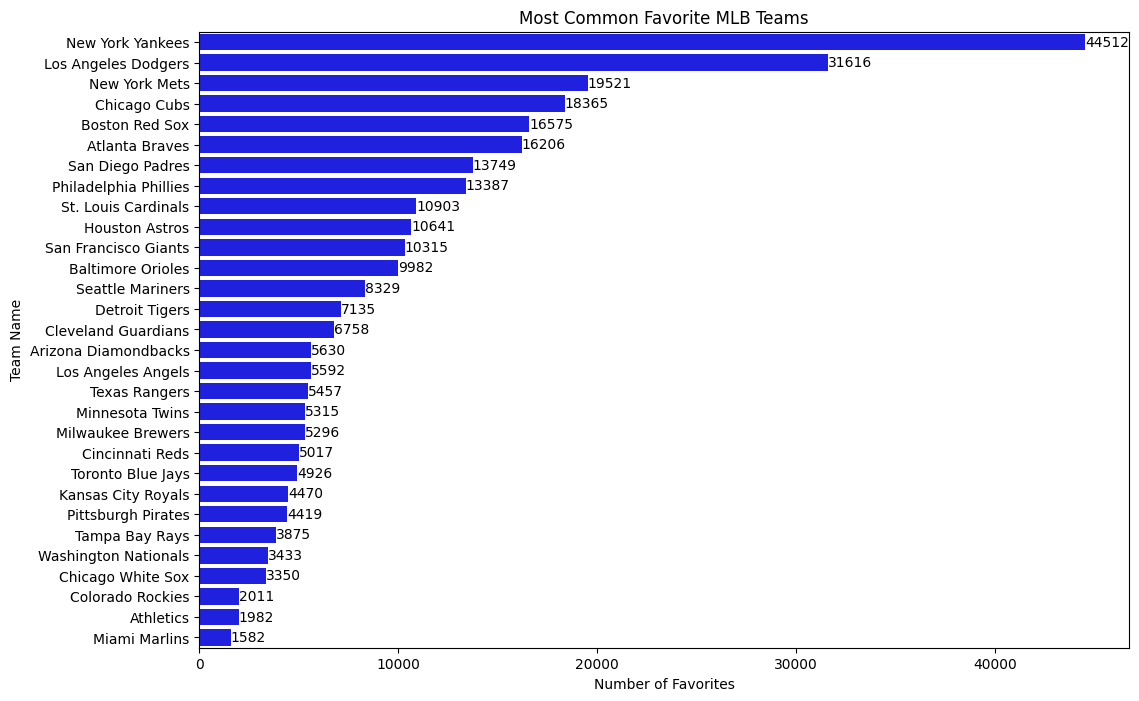

In [ ]:
#@title Look at Most Common Favorite MLB Teams
most_common_favorite_teams = (pd.merge(
  mlb_fan_favorites_df['favorite_team_id'].value_counts().reset_index().
    rename(columns = {"count": "num_favorites"}),
  teams[['id', 'name']].
    rename(columns = {"id": "team_id", "name": "team_name"}),
  left_on = 'favorite_team_id',
  right_on = 'team_id',
  how = 'left'
  )[['team_id', 'team_name', 'num_favorites']]
  )

# Create barplot showing most common favorite MLB teams
plt.figure(figsize=(12, 8))
sns.barplot(x='num_favorites', y='team_name', data=most_common_favorite_teams,
    orient='h', color='blue')
plt.title('Most Common Favorite MLB Teams')
plt.xlabel('Number of Favorites')
plt.ylabel('Team Name')

# Add text labels for # of favorites next to each bar
for index, row in most_common_favorite_teams.iterrows():
  plt.text(row['num_favorites'], index, str(row['num_favorites']),
    color='black', ha='left', va='center')

plt.show()

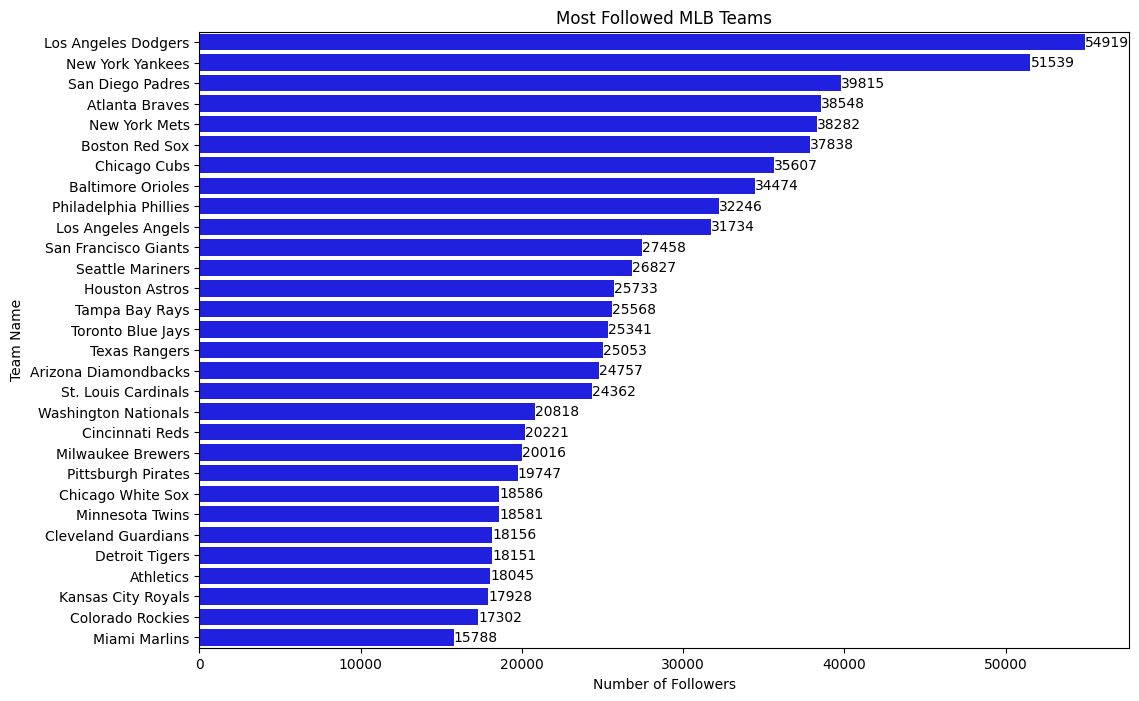

In [ ]:
#@title Look at Most Followed MLB Teams

# Explode the 'followed_team_ids' column to create 1 row for each followed team
mlb_fan_follows_expanded_df = (mlb_fan_favorites_df.
  explode('followed_team_ids').
  reset_index(drop=True)
  )

# Convert followed team IDs to integer format
mlb_fan_follows_expanded_df['followed_team_ids'] = (
  mlb_fan_follows_expanded_df['followed_team_ids'].astype('Int64'))

most_followed_teams = (pd.merge(
  mlb_fan_follows_expanded_df['followed_team_ids'].value_counts().reset_index().
    rename(columns = {"count": "num_followers"}),
  teams[['id', 'name']].
    rename(columns = {"id": "team_id", "name": "team_name"}),
  left_on = 'followed_team_ids',
  right_on = 'team_id',
  how = 'left'
  )[['team_id', 'team_name', 'num_followers']]
  )

# Create barplot showing most followed MLB teams
plt.figure(figsize=(12, 8))
sns.barplot(x='num_followers', y='team_name', data=most_followed_teams,
    orient='h', color='blue')
plt.title('Most Followed MLB Teams')
plt.xlabel('Number of Followers')
plt.ylabel('Team Name')

# Add text labels for # of followers next to each bar
for index, row in most_followed_teams.iterrows():
  plt.text(row['num_followers'], index, str(row['num_followers']),
    color='black', ha='left', va='center')

plt.show()

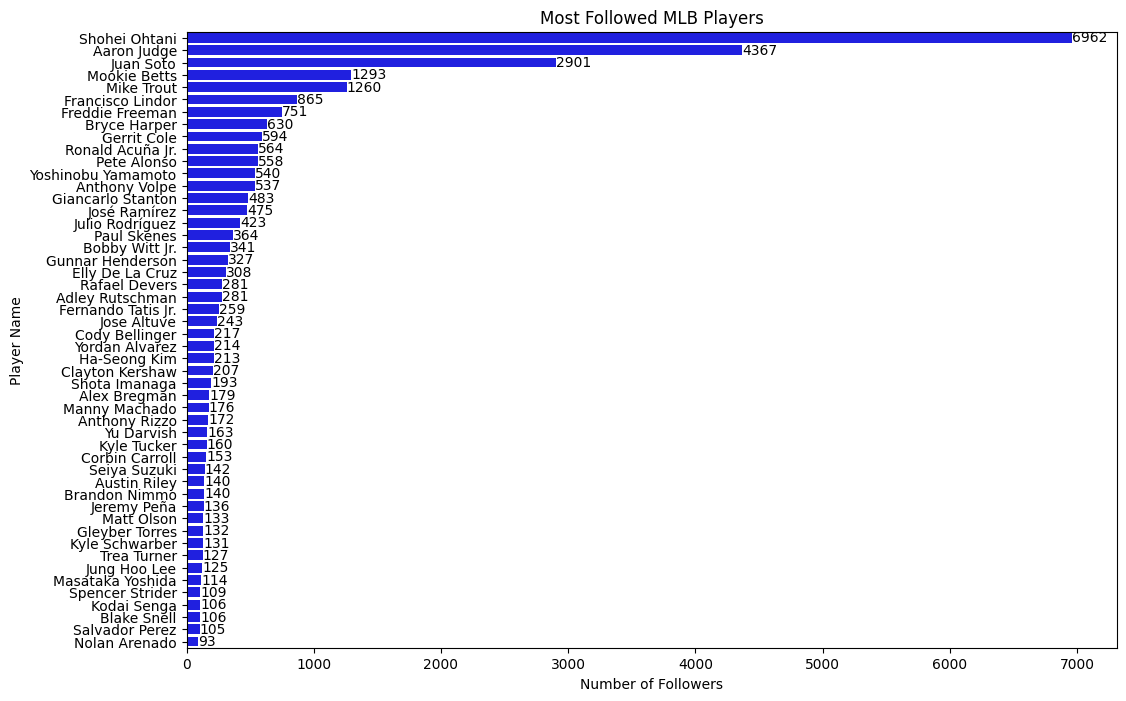

In [ ]:
#@title Look at Most Followed MLB Players

# Explode 'followed_player_ids' column to create 1 row for each followed player
mlb_fan_followed_players_expanded_df = (mlb_fan_favorites_df.
  explode('followed_player_ids').
  reset_index(drop=True)
  )

# Convert followed player IDs to integer format
mlb_fan_followed_players_expanded_df['followed_player_ids'] = (
  mlb_fan_followed_players_expanded_df['followed_player_ids'].astype('Int64'))

# Get list of Top N players by number of followers (including player names)
most_followed_players = (pd.merge(
  mlb_fan_followed_players_expanded_df['followed_player_ids'].
    value_counts().
    reset_index().
    rename(
      columns = {
        "followed_player_ids": "player_id",
        "count": "num_followers"
        }),
  players[['id', 'nameFirstLast']].
    rename(
      columns = {"id": "player_id", "nameFirstLast": "player_name"}
      ),
  on = 'player_id',
  how = 'left'
  ).
  # Filter to top 50 players
  nlargest(50, 'num_followers')
  )

most_followed_players

# Create barplot showing most followed MLB players
plt.figure(figsize=(12, 8))
sns.barplot(x='num_followers', y='player_name', data=most_followed_players,
    orient='h', color='blue')
plt.title('Most Followed MLB Players')
plt.xlabel('Number of Followers')
plt.ylabel('Player Name')

# Add text labels for # of followers next to each bar
for index, row in most_followed_players.iterrows():
  plt.text(row['num_followers'], index, str(row['num_followers']),
    color='black', ha='left', va='center')

plt.show()

# Exploring MLB Fan Content Interaction Data
---
There is [a large dataset](https://console.cloud.google.com/storage/browser/gcp-mlb-hackathon-2025/datasets/mlb-fan-content-interaction-data) with data on the interaction of MLB fans with various content on MLB digital properties. Below, we read in just 1 of the dozens of JSON files with this information in to show what it looks like.

In [ ]:
#@title Read in Example MLB Fan Content Interaction Data File from Google Cloud Storage
mlb_fan_content_interaction_json_file = 'https://storage.googleapis.com/gcp-mlb-hackathon-2025/datasets/mlb-fan-content-interaction-data/mlb-fan-content-interaction-data-000000000000.json'

mlb_fan_content_interaction_df = load_newline_delimited_json(
    mlb_fan_content_interaction_json_file)

display(mlb_fan_content_interaction_df)

,date_time_date,date_time_utc,source,user_id,slug,content_type,content_headline,team_ids,player_tags
0,2024-07-30,2024-07-31T03:21:21+00:00,iOS,AZNYWKP68NTBLWN,rodriguez-charles-combine-to-turn-great-double-play,video,"Rodriguez, Charles combine to turn great double play",[],"[691497, 800051]"
1,2024-07-30,2024-07-30T18:57:53+00:00,iOS,WZO387IQWPX4HTL,chris-okey-hits-a-walk-off-single,video,Chris Okey hits a walk-off single,[],[608360]
2,2024-07-30,2024-07-30T23:05:11+00:00,iOS,JIOSQ23LVKD7RHO,chris-okey-hits-a-walk-off-single,video,Chris Okey hits a walk-off single,[],[608360]
3,2024-07-30,2024-07-30T19:44:56+00:00,iOS,V9W9G90G6SQZZPF,chris-okey-hits-a-walk-off-single,video,Chris Okey hits a walk-off single,[],[608360]
4,2024-07-30,2024-07-31T01:46:07+00:00,iOS,2MM894G4MF56Q2O,chris-okey-hits-a-walk-off-single,video,Chris Okey hits a walk-off single,[],[608360]
...,...,...,...,...,...,...,...,...,...
648659,2024-07-30,2024-07-30T20:25:25+00:00,Web,GP4BG6RRDVVLFAU,world-baseball-classic-2026-host-sites-announced,article,"Tokyo, San Juan, Houston and Miami announced as World Baseball Classic 2026 hosts",[940],[]
648660,2024-07-30,2024-07-30T17:19:17+00:00,Web,B51H2FOKIG6PKMN,world-baseball-classic-2026-host-sites-announced,article,"Tokyo, San Juan, Houston and Miami announced as World Baseball Classic 2026 hosts",[940],[]
648661,2024-07-30,2024-07-30T21:04:24+00:00,Web,B51H2FOKIG6PKMN,world-baseball-classic-2026-host-sites-announced,article,"Tokyo, San Juan, Houston and Miami announced as World Baseball Classic 2026 hosts",[940],[]
648662,2024-07-30,2024-07-30T17:12:17+00:00,Web,5ANIWQP1T37E2KV,team-korea-world-baseball-classic-2023-roster,article,"Pair of Major Leaguers, KBO MVP highlight Korea roster",[1171],[]


In [ ]:
#@title See What Dates, Content Types, and Sources Are Present
date_counts = mlb_fan_content_interaction_df['date_time_date'].value_counts()

display(date_counts)

content_type_counts = (mlb_fan_content_interaction_df['content_type'].
    value_counts())

display(content_type_counts)

content_source_counts = (mlb_fan_content_interaction_df['source'].
    value_counts())

display(content_source_counts)

,count
date_time_date,
2024-07-30,648664


,count
content_type,
video,465867
article,182797


,count
source,
iOS,353133
Web,224632
Android,70899


In [ ]:
#@title Find Content Pieces with Most Interaction in This Data
interaction_by_content = (mlb_fan_content_interaction_df[
    ['slug', 'content_type', 'content_headline']].
    value_counts().
    reset_index().
    rename(columns = {"count": "num_interactions"})
    )

display(interaction_by_content)

,slug,content_type,content_headline,num_interactions
0,every-2024-mlb-trade-deadline-deal,article,Tracking every 2024 Trade Deadline deal,35181
1,c-2523586283,video,Gameday Video Placement clip,19273
2,jazz-chisholm-jr-homers-17-on-a-fly-ball-to-right-field-juan-soto-scores,video,Jazz Chisholm Jr.'s second homer of the day (17),17492
3,aaron-nola-in-play-run-s-to-jazz-chisholm-jr,video,Jazz Chisholm Jr.'s RBI groundout,11859
4,mlb-rumors-trades-and-signings,article,'Growing sense' this 8-time All-Star will be traded,10738
...,...,...,...,...
7984,jackson-holliday-orioles-callup,article,The Jackson Holliday era has begun for Baltimore,1
7985,jackson-holliday-hits-first-homer-since-triple-a-return,article,Holliday hits first homer since returning to Triple-A,1
7986,jackson-chourio-s-two-run-double-x1182,video,Jackson Chourio's two-run double,1
7987,jackson-chourio-s-home-run-through-bat-tracking-data,video,Jackson Chourio's home run through bat tracking data,1


In [ ]:
#@title Generate MLB.com Link for Article or Video for Specific Content Piece
# Pick single content piece to get link for
content_slug = "every-2024-mlb-trade-deadline-deal" # @param {type:"string"}
content_type = "article" # @param {type:"string"} ['article', 'video']

content_type_cat = ('news' if (content_type == 'article') else 'video')

content_mlb_com_link = f'https://www.mlb.com/{content_type_cat}/{content_slug}'

print(content_mlb_com_link)

https://www.mlb.com/news/every-2024-mlb-trade-deadline-deal


# Exploring MLB Caption Data
---

There is [an interesting text-heavy dataset](https://console.cloud.google.com/storage/browser/gcp-mlb-hackathon-2025/datasets/mlb-caption-data) with captions from the game broadcast of some MLB games, mapped to timestamps within the game (so that you can potentially try to match play-level data with these captions). Below, we read in all of the JSON files with this information in, combine them into 1 data frame, and do some preliminary analysis.

In [ ]:
#@title Read in All MLB Caption Data from Google Cloud Storage
mlb_captions_base_url = 'https://storage.googleapis.com/gcp-mlb-hackathon-2025/datasets/mlb-caption-data/mlb-captions-data-*.json'
all_dfs = []
i = 0

# Loop over files labeled ""...00" to "...12"
for i in np.arange(0, 13):
    this_url = mlb_captions_base_url.replace("*", str(i).zfill(12))
    this_df = load_newline_delimited_json(this_url)
    all_dfs.append(this_df)
    i += 1

mlb_captions_df = pd.concat(all_dfs, ignore_index=True)

display(mlb_captions_df.head())

Skipping invalid JSON line:  due to error: Expecting value: line 1 column 1 (char 0)
Error downloading data: 404 Client Error: Not Found for url: https://storage.googleapis.com/gcp-mlb-hackathon-2025/datasets/mlb-caption-data/mlb-captions-data-000000000009.json
Error downloading data: 404 Client Error: Not Found for url: https://storage.googleapis.com/gcp-mlb-hackathon-2025/datasets/mlb-caption-data/mlb-captions-data-000000000011.json


,caption_start,caption_end,caption_text,write_date,game_pk,feed_type
0,02:13:28,02:13:42.610000,"And part of my thinking here, Steven Vogt leaving him in is not so much the fifth inning that may be sacrificing this matchup in the fifth, but perhaps it will be a righty when he comes around aga...",2024-09-20T07:32:20.420407+00:00,746579,A
1,04:04:23.465000,04:04:23.630000,So.,2024-09-20T07:32:20.420407+00:00,746579,A
2,03:16:07.572000,03:16:07.750000,100.,2024-09-20T07:32:20.420407+00:00,746579,A
3,01:08:21.947000,01:08:22.090000,Now.,2024-09-20T07:32:20.420407+00:00,746579,A
4,00:58:04.797000,00:58:04.960000,One.,2024-09-20T07:32:20.420407+00:00,746579,A


In [ ]:
#@title See What Dates and Feed Types Are Present
# Convert 'write_date' to date only field
mlb_captions_df['write_date_only'] = (pd.to_datetime(
    mlb_captions_df['write_date']).dt.date)

date_counts = mlb_captions_df['write_date_only'].value_counts()

display(date_counts)

feed_type_counts = mlb_captions_df['feed_type'].value_counts()

display(feed_type_counts)

,count
write_date_only,
2024-09-19,72721
2024-09-22,67778
2024-09-21,58176
2024-09-26,53861
2024-09-18,50628
2024-09-29,44870
2024-09-25,41066
2024-09-27,34961
2024-09-17,27606


,count
feed_type,
H,271118
A,269017


In [ ]:
#@title Get MLB Film Room Video Clip for Last Play from Specific Game
# Pick game to get last play from (default is game_pk 747066, for Braves-Royals
# game with Travis d'Arnaud walk-off HR on 9/28/2024)
game_pk = '747066' #@param{type:"string"}

single_game_feed_url = f'https://statsapi.mlb.com/api/v1.1/game/{game_pk}/feed/live'

single_game_info_json = json.loads(requests.get(single_game_feed_url).content)

single_game_play = single_game_info_json['liveData']['plays']['currentPlay']

single_game_play_id = single_game_play['playEvents'][-1]['playId']

single_play_video_url = f'https://www.mlb.com/video/search?q=playid=\"{single_game_play_id}\"'

display(single_play_video_url)

'https://www.mlb.com/video/search?q=playid="ba04fcba-8fea-4f49-8768-6dc9230bbbe5"'

In [ ]:
#@title Get Captions Data Corresponding to Specific Play

# This is specific to the walk-off HR in game_pk 747066, with caption time codes
# found manually
single_play_captions = (mlb_captions_df[
    (mlb_captions_df['game_pk'] == game_pk)
    &
    (mlb_captions_df['feed_type'] == 'H')
    &
    (mlb_captions_df['caption_start'] >= '03:08:25.00000')
    &
    (mlb_captions_df['caption_end'] <= '03:10:21.0000')
    ].
    sort_values(['caption_start']).
    reset_index(drop = True)
    )

display(single_play_captions[['caption_start', 'caption_end', 'caption_text']])

,caption_start,caption_end,caption_text
0,03:08:25.594000,03:08:38.740000,">> Now Travis Otano first time facing the Royals since 2016, Travis has not seen much of the Royals, but he's got a spohere in the ninthith one out."
1,03:08:38.740000,03:08:45.310000,body on where he can ctainly make an impact impact.
2,03:08:45.314000,03:09:10.130000,"Downstairs, two balls, no strikes to the Braves catcher catcherDa catcherDat catcherDa catcherDar field."
3,03:09:10.138000,03:09:15.240000,It's deep and it's gone gone.
4,03:09:15.243000,03:09:19.580000,>> Travis Darnel with the biggest home run of the Braves season.
5,03:09:19.581000,03:09:25.350000,And they walk it off 2 to 1.
6,03:09:25.354000,03:09:31.360000,Now Now.
7,03:09:31.360000,03:10:03.220000,Larrondo Dalvy Dalvy.
8,03:10:03.225000,03:10:08.860000,Something is eling different about this team right now now.
9,03:10:08.864000,03:10:10.380000,>> And what we are seeing when it matters.


# Other Resources
---

Below are a few other resources related to the hackathon or MLB in general that may be useful.

*   [Google Cloud x MLB Hackathon Resources GitHub Repo](https://github.com/MajorLeagueBaseball/google-cloud-mlb-hackathon)
*   [MLB Glossary](https://www.mlb.com/glossary)
*   ["MLB-StatsAPI" Python library to wrap MLB Stats API](https://pypi.org/project/MLB-StatsAPI/)
*   ["baseballR" R library to wrap MLB Stats API](https://cran.r-project.org/web/packages/baseballr/index.html)